In [90]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [91]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn as sns

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [95]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [96]:
TRAIN_DATASET_PATH = './new_train.csv'

In [97]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [99]:
TARGET_NAME = 'cardio'

In [100]:
NUM_FEATURE_NAMES = ['age', 'height', 'weight','ap_hi', 'ap_lo']
CAT_FEATURE_NAMES = ['gender', 'cholesterol']
BASE_FEATURE_NAMES = ['gluc', 'smoke', 'alco', 'active']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + BASE_FEATURE_NAMES

Model learning

In [101]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21, stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.500306
1    0.499694
Name: cardio, dtype: float64

0    0.500286
1    0.499714
Name: cardio, dtype: float64

In [103]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = NUM_FEATURE_NAMES
cat_cols = CAT_FEATURE_NAMES
base_cols = BASE_FEATURE_NAMES

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [104]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.16034937,  0.6851458 ,  1.17291511, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.38632036, -0.04531331, -0.63970763, ...,  0.        ,
         0.        ,  1.        ],
       [-1.28092434,  0.44165943,  1.24263137, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.36232249,  0.07642988, -0.43055885, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46005842, -0.53228605, -0.98828892, ...,  0.        ,
         0.        ,  1.        ],
       [-1.86407527,  0.07642988, -0.29112633, ...,  0.        ,
         0.        ,  1.        ]])

In [105]:
tree = DecisionTreeClassifier(random_state=21, max_depth=128, 
                              class_weight={0:1, 1:4},
                              min_samples_leaf = 8)

In [107]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', tree),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]
evaluate_preds(classifier, X_train, X_test, y_train, y_test)

CV score is 0.7328878930488012+-0.009385051153745477
TRAIN

              precision    recall  f1-score   support

           0       0.94      0.51      0.66     24515
           1       0.66      0.97      0.79     24485

    accuracy                           0.74     49000
   macro avg       0.80      0.74      0.72     49000
weighted avg       0.80      0.74      0.72     49000

TEST

              precision    recall  f1-score   support

           0       0.75      0.40      0.52     10506
           1       0.59      0.87      0.70     10494

    accuracy                           0.63     21000
   macro avg       0.67      0.63      0.61     21000
weighted avg       0.67      0.63      0.61     21000

CONFUSION MATRIX

col_0      0     1
cardio            
0       4229  6277
1       1403  9091


In [108]:
from sklearn.metrics import mean_absolute_error, r2_score

In [110]:
predictions =  classifier.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.3657142857142857, -0.4628576205249375)

In [111]:
pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)

pred_proba_test = classifier.predict_proba(X_test)

In [112]:
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix, accuracy_score, f1_score

In [113]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.7373469387755102
Accuracy на тесте 0.6342857142857142


In [114]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.75      0.40      0.52     10506
           1       0.59      0.87      0.70     10494

    accuracy                           0.63     21000
   macro avg       0.67      0.63      0.61     21000
weighted avg       0.67      0.63      0.61     21000



In [115]:
r2_v = r2_score(y_test, pred_test)
r2_v

-0.4628576205249375

In [117]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7348382036659894
log loss score: 2.794562163318122


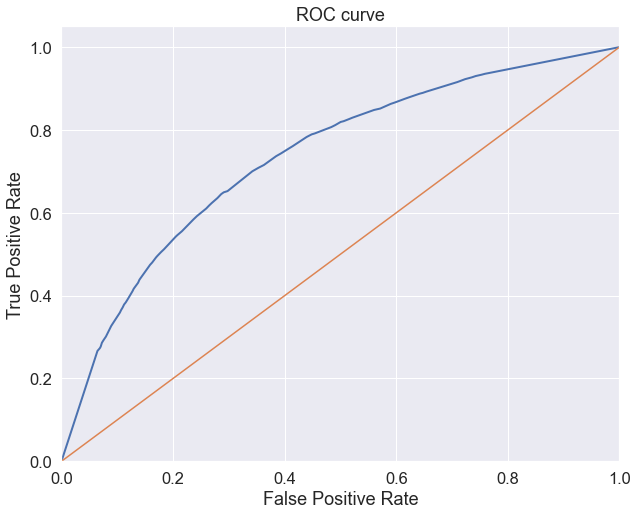

In [118]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()